<a href="https://colab.research.google.com/github/phanee16/Tweet-Emotion-Recognition-with-TensorFlow./blob/main/Tweet_Emotion_Recognition_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [66]:
!pip install nlp

In [67]:
!pip install datasets


In [68]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import pandas as pd



def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [69]:

import datasets

# Load the 'emotion' dataset
dataset = datasets.load_dataset('emotion')


  0%|          | 0/3 [00:00<?, ?it/s]

In [70]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [79]:
train = dataset['train']
test = dataset['test']
valid = dataset['validation']

In [80]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,labels

In [81]:
tweets,labels = get_tweet(train)

In [82]:
tweets[0],labels[0]

('i didnt feel humiliated', 0)

In [83]:
# Dictionary to map labels to emotions
label_to_emotion = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Modify the labels in the train data directly using list comprehension
train = [{'text': tweet['text'], 'label': label_to_emotion[tweet['label']]} for tweet in train]
test = [{'text': tweet['text'], 'label': label_to_emotion[tweet['label']]} for tweet in test]
valid = [{'text': tweet['text'], 'label': label_to_emotion[tweet['label']]} for tweet in valid]
# Example usage to print the first tweet and its modified label
tweets, labels = get_tweet(train)
(tweets[0], labels[0])


('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [85]:
tokenizer = Tokenizer(num_words = 10000,oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [86]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [87]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

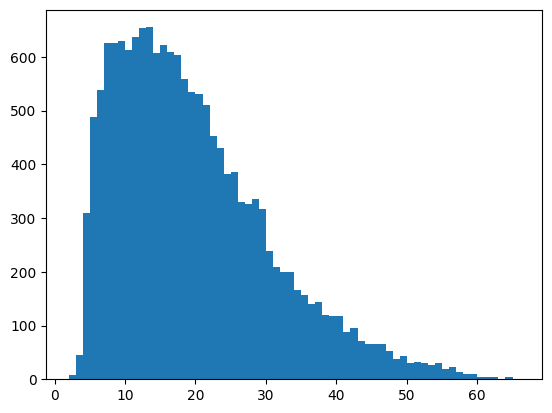

In [88]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins = len(set(lengths)))
plt.show()

In [90]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [91]:
def get_sequence(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post',padding = 'post',maxlen = maxlen)
  return padded

In [92]:
padded_train_sequences = get_sequence(tokenizer,tweets)

In [93]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [94]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

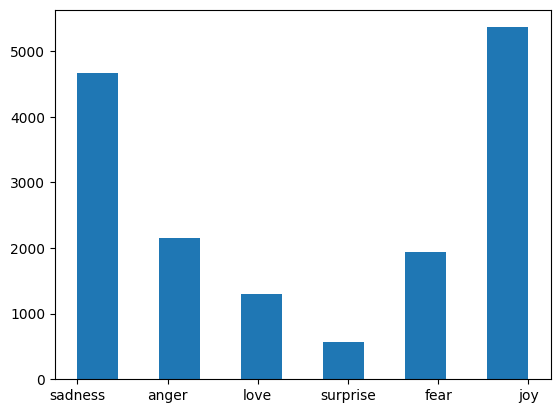

In [97]:
plt.hist(labels,bins = 11)
plt.show()

In [99]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((i,c) for i,c in enumerate(classes))

In [101]:
class_to_index

{'joy': 0, 'sadness': 1, 'anger': 2, 'surprise': 3, 'love': 4, 'fear': 5}

In [100]:
index_to_class

{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'surprise', 4: 'love', 5: 'fear'}

In [102]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [103]:
train_labels = names_to_ids(labels)

In [104]:
train_labels[0]

1

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [105]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(64, activation='softmax'),

])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',   # Use 'categorical_crossentropy' if you one-hot encode your labels
              metrics=['accuracy'])



In [106]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2624      
                                                                 
Total params: 178,304
Trainable params: 178,304
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [107]:
val_tweets,val_labels = get_tweet(valid)
val_seq = get_sequence(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)

In [108]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [111]:
from tensorflow.keras.callbacks import EarlyStopping

# Define callbacks
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience=3, restore_best_weights=True)

h = model.fit(padded_train_sequences,
              train_labels,
              epochs=20,
              validation_data=(val_seq, val_labels),
              callbacks=[early_stopping])


Epoch 1/20
500/500 [==============================] - 47s 65ms/step - loss: 1.7478 - accuracy: 0.3231 - val_loss: 1.5864 - val_accuracy: 0.3520
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 1.5813 - accuracy: 0.3273 - val_loss: 1.5891 - val_accuracy: 0.3520
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 1.5795 - accuracy: 0.3288 - val_loss: 1.5850 - val_accuracy: 0.3520
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 1.5496 - accuracy: 0.3356 - val_loss: 1.4201 - val_accuracy: 0.3930
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 1.2302 - accuracy: 0.4311 - val_loss: 1.1749 - val_accuracy: 0.4830
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.9957 - accuracy: 0.5176 - val_loss: 1.0329 - val_accuracy: 0.4735
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.8645 - accuracy: 0.5654 - val_loss: 0.9819 - val_accuracy: 0.

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

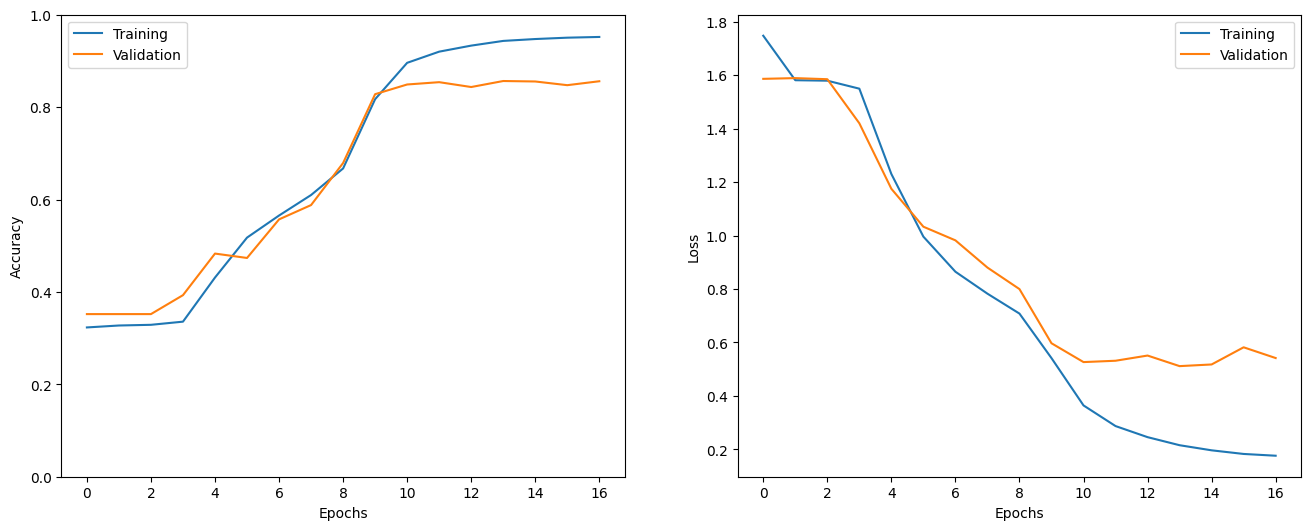

In [112]:
show_history(h)

In [113]:
test_tweets,test_labels = get_tweet(test)
test_seq = get_sequence(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [114]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.5073 - accuracy: 0.8695


In [121]:
i = random.randint(0,len(test_labels)-1)

print('Sentence: ' , test_tweets[i])
print('Label:  ' , index_to_class[test_labels[i]])


p = model.predict(np.expand_dims(test_seq[i],axis = 0))[0]
pred_class  = index_to_class[np.argmax(p).astype('uint8')]

print("Predicted Emotion: ", pred_class)

Sentence:  i would feel productive
Label:   joy
1/1 [==============================] - 0s 23ms/step
Predicted Emotion:  joy


In [136]:
preds = model.predict(test_seq)

63/63 [==============================] - 0s 7ms/step


In [137]:
# Get the predicted classes from the probability predictions
preds_classes = np.argmax(preds, axis=1)


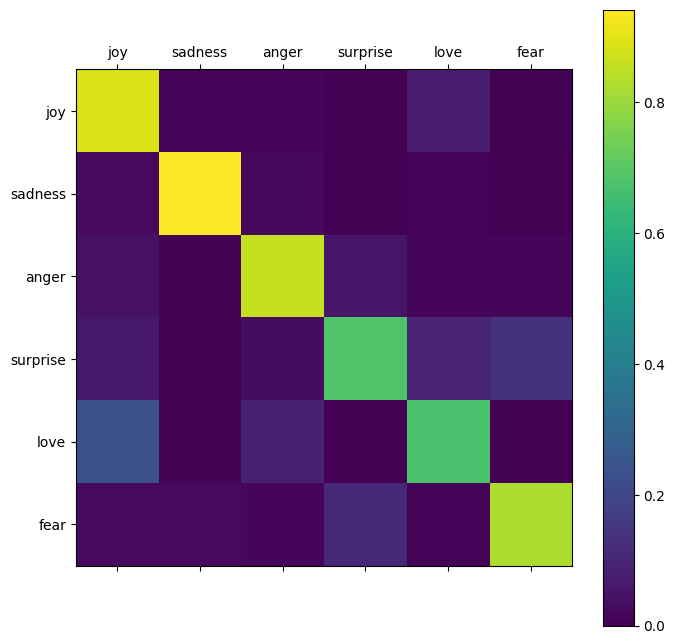

In [138]:
show_confusion_matrix(test_labels, preds_classes, classes=list(classes))


In [140]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_labels, preds_classes)
conf_matrix

array([[619,   6,  10,   3,  53,   4],
       [ 14, 547,  12,   2,   6,   0],
       [ 12,   2, 236,  15,   5,   5],
       [  4,   0,   2,  45,   6,   9],
       [ 37,   1,  14,   0, 107,   0],
       [  5,   5,   3,  24,   2, 185]])